In [1]:
import pandas as pd
from datetime import date
from mosqlient.datastore import Infodengue
from mosqlient.models.baseline import Arima

/opt/homebrew/Caskroom/miniforge/base/envs/mosqlient/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mosqlient/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mosqlient/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_ADM_level" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mosqlient/lib/python3

Before applying the Baseline model, it is necessary to load the data. In this example, we will use the dengue data in Rio de Janeiro city (geocode = 3304557). The baseline model is univariate, so it will define just one column to be forecast, the `casos` column. This column must be renamed' y' before being passed to the model. It's also necessary to set the index of the dataframe as a datetime index. 

In [2]:
disease = 'dengue'
geocode = 3304557 
end_date = date.today().strftime('%Y-%m-%d')

df = Infodengue.get(per_page =  100,
                            disease =  disease,
                            start = "2010-01-01",
                            end = end_date, 
                            geocode = geocode)

df.set_index('data_iniSE', inplace = True )
    
df.index = pd.to_datetime(df.index)
    
df = df.sort_index()
    
df = df.asfreq('W')
        
df = df[['casos']].rename(columns = {'casos':'y'})

df = df.ffill()

df.head()

,y
data_iniSE,
2010-01-03,30.0
2010-01-10,44.0
2010-01-17,46.0
2010-01-24,47.0
2010-01-31,68.0


The cell below calls the class associated with the Arima baseline model. 

The ARIMA model is defined by: 

$$y_t = c + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t,$$

$p$ - order of the autoregressive part;

$d$ - degree of first differencing involved;

$q$ - order of the moving average part. 

If $d=1$: $y_t = Y_t - Y_{t-1},$ 

If $d=2$: $y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}),$
and so on. 



To call the class, you must instantiate the `df` parameter, which will be used to train the model and make predictions of the model in-sample and the out-of-sample. 

Internally, before the model's training and application, the data is transformed using a `boxcox` transformation. The `lambda` parameter is estimated by optimization. Also, during the training step, the model's parameters are optimized using the `aic` metric and the `auto_arima` function of the `pmdarima` package. 

In [3]:
m_arima = Arima(df = df)

m_arima

### Train the model 

To use this method is necessary to define a data of begin and end of training. This filter by date is applied on the `df` passed in the last step. 

In [4]:
model = m_arima.train(train_ini_date='2010-01-01', train_end_date = '2021-12-31')

model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-291.303, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-263.031, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-297.620, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.702, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-264.935, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-302.773, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-301.987, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-308.875, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-301.181, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-306.876, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-305.545, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-306.272, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-310.782, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-303.034, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]          

ARIMA(maxiter=100, order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#### Predictions in sample

Performace of the model in the sample

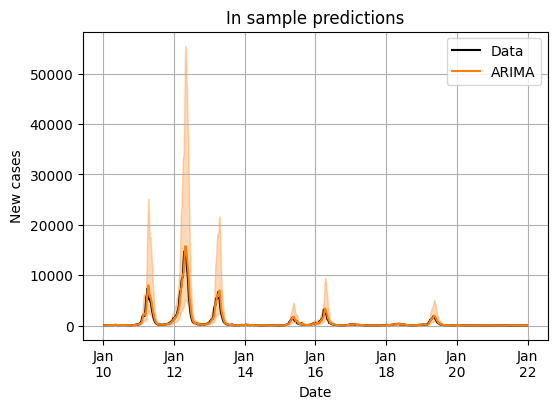

In [5]:
df_in_sample = m_arima.predict_in_sample(plot = True)

In [6]:
df_in_sample.head()

,dates,preds,lower,upper,data
1,2010-01-10,29.999999,17.195241,54.460515,44.0
2,2010-01-17,40.109447,22.919088,73.070447,46.0
3,2010-01-24,47.548675,26.956062,87.413968,47.0
4,2010-01-31,48.534823,27.525448,89.188390,68.0
5,2010-02-07,64.439819,35.896396,120.889823,56.0


#### Predictions out of sample

The out-of-sample performance of the models starts after the last data used to train the model, which is the `train_end_date` parameter defined in the `train()` method.

In this method, it is necessary to define the end date for evaluation and the horizon that the model will forecast. During the out-of-sample prediction, what is done is essentially the forecast step multiple times. For example, if our data has indices 1-16 and the horizon is 4, the first forecast is for indices 1-4. After that, we update the Arima model using the actual observations of indices 1-4 and forecast the indices 5-8. This is done until the end date.

,date,preds,lower,upper,data
0,2022-01-02,3.614690,2.380062,5.611839,21.0
1,2022-01-09,3.433250,2.039615,5.982624,14.0
2,2022-01-16,3.252150,1.717527,6.491965,22.0
3,2022-01-23,3.118710,1.490771,7.008234,19.0
0,2022-01-30,21.331039,12.570340,37.513894,31.0


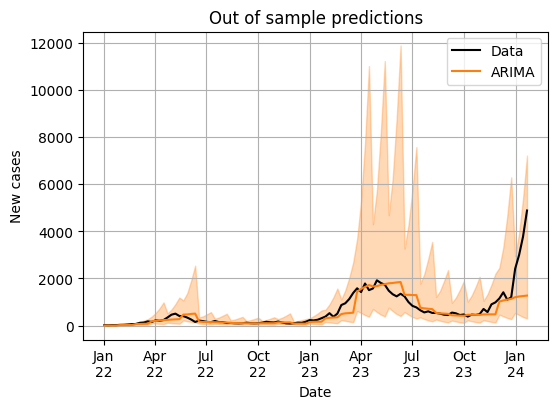

In [9]:
df_out = m_arima.predict_out_of_sample(horizon = 4, end_date = '2023-12-31', plot = True)

df_out.head()    

### Forecast 

To forecast is necessary to train the model before. The forecast will be done after the last day used in the training step. 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-217.015, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-171.355, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-200.885, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-193.904, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-173.145, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-206.495, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-218.871, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-208.031, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-209.514, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-216.921, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-207.908, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-217.491, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-220.704, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-209.762, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]          

,dates,preds,lower,upper
0,2024-01-07,2144.869744,976.449746,5006.945321
1,2024-01-14,2434.726023,889.519449,7378.609325
2,2024-01-21,2532.133941,729.243190,10313.101849
3,2024-01-28,2677.898608,625.208621,14332.796484


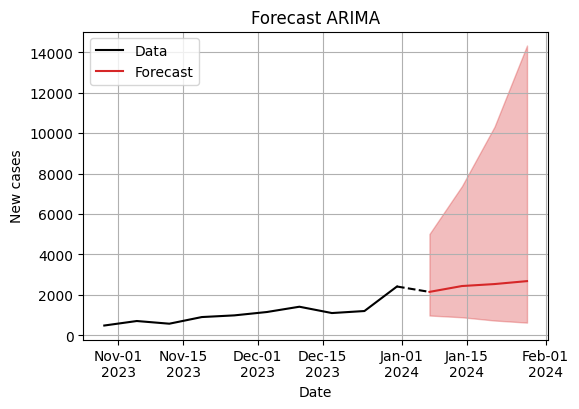

In [7]:
model = m_arima.train( train_ini_date='2010-01-01', train_end_date = '2023-12-31')

df_for = m_arima.forecast(horizon = 4, plot = True, last_obs = 10)

df_for.head()